In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
import sys
sys.path.append('..')

from stmt.regressor.stmt import StochasticThresholdModelTrees
from stmt.threshold_selector import NormalGaussianDistribution
from stmt.criterion import MSE

# Definition of the drawing function

In [3]:
def my_plot(X1_train, X2_train, Y_train, X1_test=None, X2_test=None, Y_test=None, Yp_test=None,
                       title=None, fontsize=None, legend=False):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['mathtext.fontset'] = 'cm'
    plt.rcParams['axes.linewidth'] = 1.0

    # Draw training data
    ax.scatter(X1_train, X2_train, Y_train, s=30, c='b', marker='o', label='Training')
    min_x1 = X1_train.min()
    max_x1 = X1_train.max()
    min_x2 = X2_train.min()
    max_x2 = X2_train.max()
    min_y = Y_train.min()
    max_y = Y_train.max()
    
    #  Draw test data
    if (X1_test is not None) and (X2_test is not None) and (Y_test is not None):
        ax.scatter(X1_test, X2_test, Y_test, s=2, c='y', marker=',', label='Test')
        min_x1 = min(min_x1, X1_test.min())
        max_x1 = max(max_x1, X1_test.max())
        min_x2 = min(min_x2, X2_test.min())
        max_x2 = max(max_x2, X2_test.max())
        min_y = min(min_y, Y_test.min())
        max_y = max(max_y, Y_test.max())
      
    # Draw predicted value
    if (X1_test is not None) and (X2_test is not None) and (Yp_test is not None):
        ax.scatter(X1_test, X2_test, Yp_test, s=5, c='r', marker='^', label='Prediction')
        min_y = min(min_y, Yp_test.min())
        max_y = max(max_y, Yp_test.max())
    
    # Drawing range settings
    ax.set_xlim(min_x1 - 0.05 * (max_x1 - min_x1), max_x1 + 0.05 * (max_x1 - min_x1))
    ax.set_ylim(min_x2 - 0.05 * (max_x2 - min_x2), max_x2 + 0.05 * (max_x2 - min_x2))
    ax.set_zlim(min_y - 0.05 * (max_y - min_y), max_y + 0.05 * (max_y - min_y))
    plt.tick_params(labelsize=fontsize)
    
    if title is not None:
        plt.title(title, fontsize=fontsize)
    ax.set_xlabel(r"$x_1$", fontsize=fontsize)
    ax.set_ylabel(r"$x_2$", fontsize=fontsize)
    ax.set_zlabel(r"$y$", fontsize=fontsize)
    if legend:
        plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=fontsize)
    
    # Output
    plt.tight_layout()
    plt.show()

# Heatmap

In [4]:
def heat(Y_test, Yp_test, vmax=10, width=None, length=None, ticklabel=None,
                title=None, fontsize=None):
    fig = plt.figure()
    
    error = abs(Y_test - Yp_test).reshape(len(width), len(length))
    sns.heatmap(error, vmax=vmax, xticklabels=ticklabel, yticklabels=ticklabel)
    if title is not None:
        plt.title(title, fontsize=fontsize)
    plt.show()

# Sphere function: $y=x_1^2+x_2^2 + noise$

In [5]:
def sphere(X1, X2):
    return X1 ** 2 + X2 ** 2

x1_train = np.arange(-5, 5.2, 0.2)
x2_train = np.arange(-5, 5.2, 0.2)

X1_train, X2_train = np.meshgrid(x1_train, x2_train)
y_train = sphere(X1_train, X2_train)
np.random.seed(0)
X1_train += np.random.randn(X1_train.shape[0], X1_train.shape[1]) * 0.1
X2_train += np.random.randn(X2_train.shape[0], X2_train.shape[1]) * 0.1
y_train += np.random.randn(y_train.shape[0]) * 0.5
y_train = y_train.flatten()

X_train = np.array([[X1, X2] for X1 in x1_train for X2 in x2_train])

In [6]:
def f(X1, X2):
    return X1**2 + X2**2

# 学習データ
x1_train = np.arange(-3, 3.2, 0.2)
x2_train = np.arange(-3, 3.2, 0.2)

X1_train, X2_train = np.meshgrid(x1_train, x2_train)
Y_train = f(X1_train, X2_train)
np.random.seed(0)
X1_train += np.random.randn(X1_train.shape[0], X1_train.shape[1]) * 0.1
X2_train += np.random.randn(X2_train.shape[0], X2_train.shape[1]) * 0.1
Y_train += np.random.randn(Y_train.shape[0]) * 0.5

# テストデータ
x1_test = np.arange(-5, 5.2, 0.2)
x2_test = np.arange(-5, 5.2, 0.2)

X1_test, X2_test = np.meshgrid(x1_test, x2_test)
Y_test = f(X1_test, X2_test)
X1_test += np.random.randn(X1_test.shape[0], X1_test.shape[1]) * 0.1
X2_test += np.random.randn(X2_test.shape[0], X2_test.shape[1]) * 0.1
Y_test += np.random.randn(Y_test.shape[0]) * 0.5

<IPython.core.display.Javascript object>


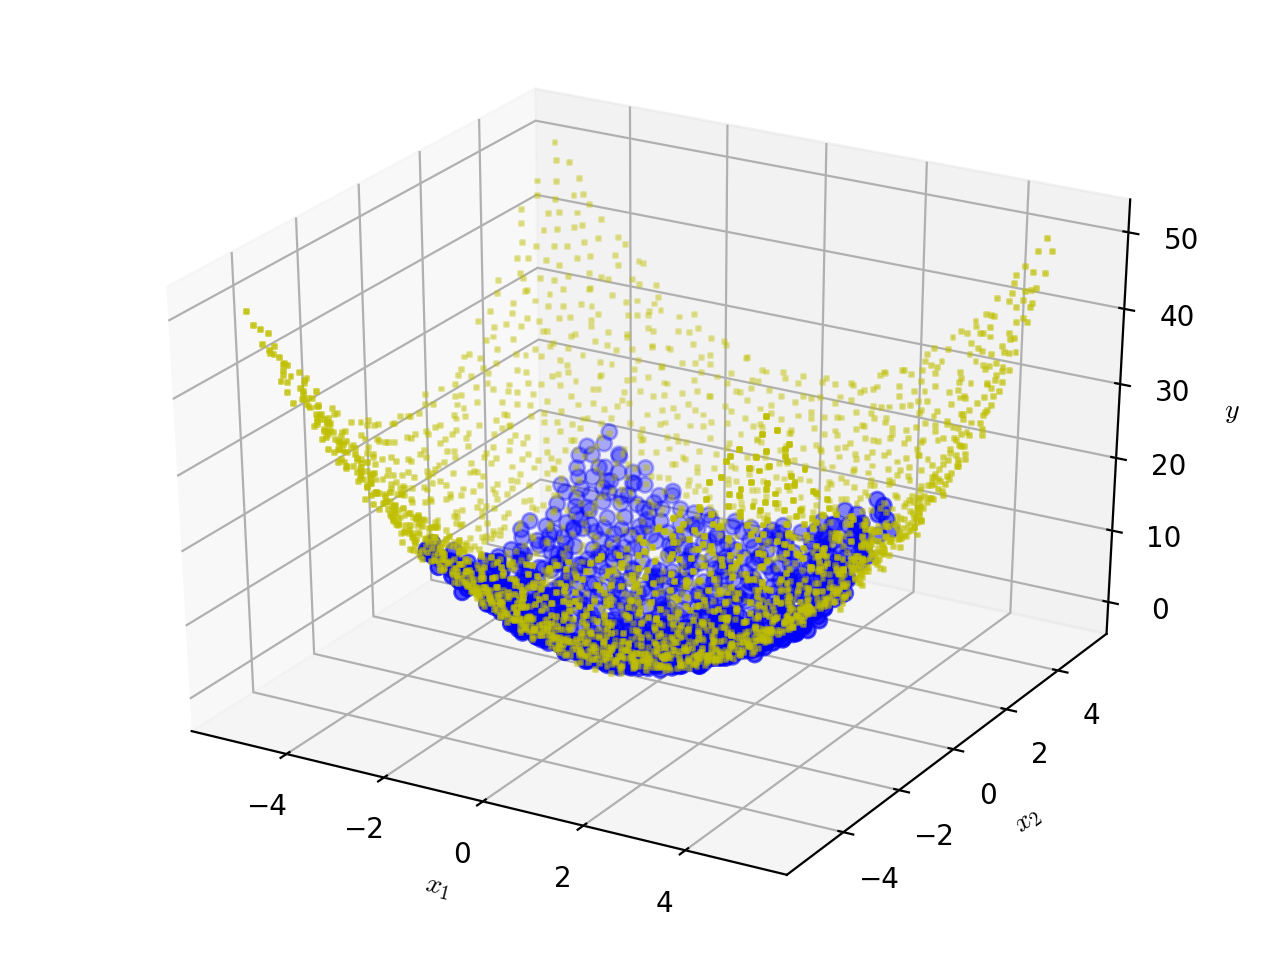

In [7]:
X_train = np.array([[X1, X2] for X1 in x1_train.flatten() for X2 in x2_train.flatten()])
Y_train = Y_train.flatten()

X_test = np.array([[X1, X2] for X1 in x1_test.flatten() for X2 in x2_test.flatten()])
Y_test = Y_test.flatten()

my_plot(X1_train, X2_train, Y_train, X1_test, X2_test, Y_test)

## Random Forest

<IPython.core.display.Javascript object>


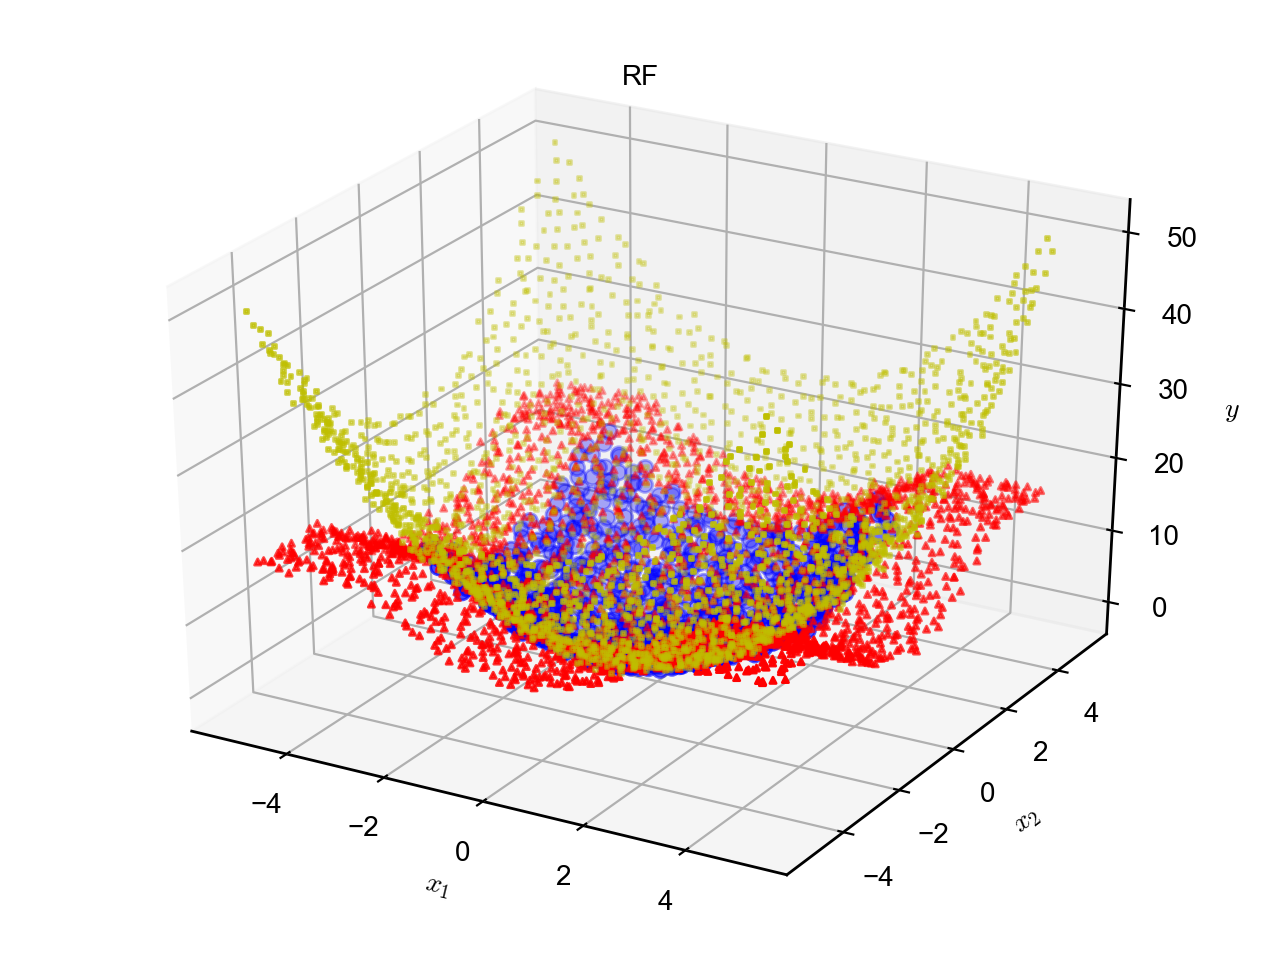

In [8]:
model_RF = RandomForestRegressor(n_estimators=300)
model_RF.fit(X_train, Y_train)
Yp_test_RF = model_RF.predict(X_test)

my_plot(X1_train, X2_train, Y_train, X1_test, X2_test, Y_test, Yp_test_RF, title="RF")

<IPython.core.display.Javascript object>


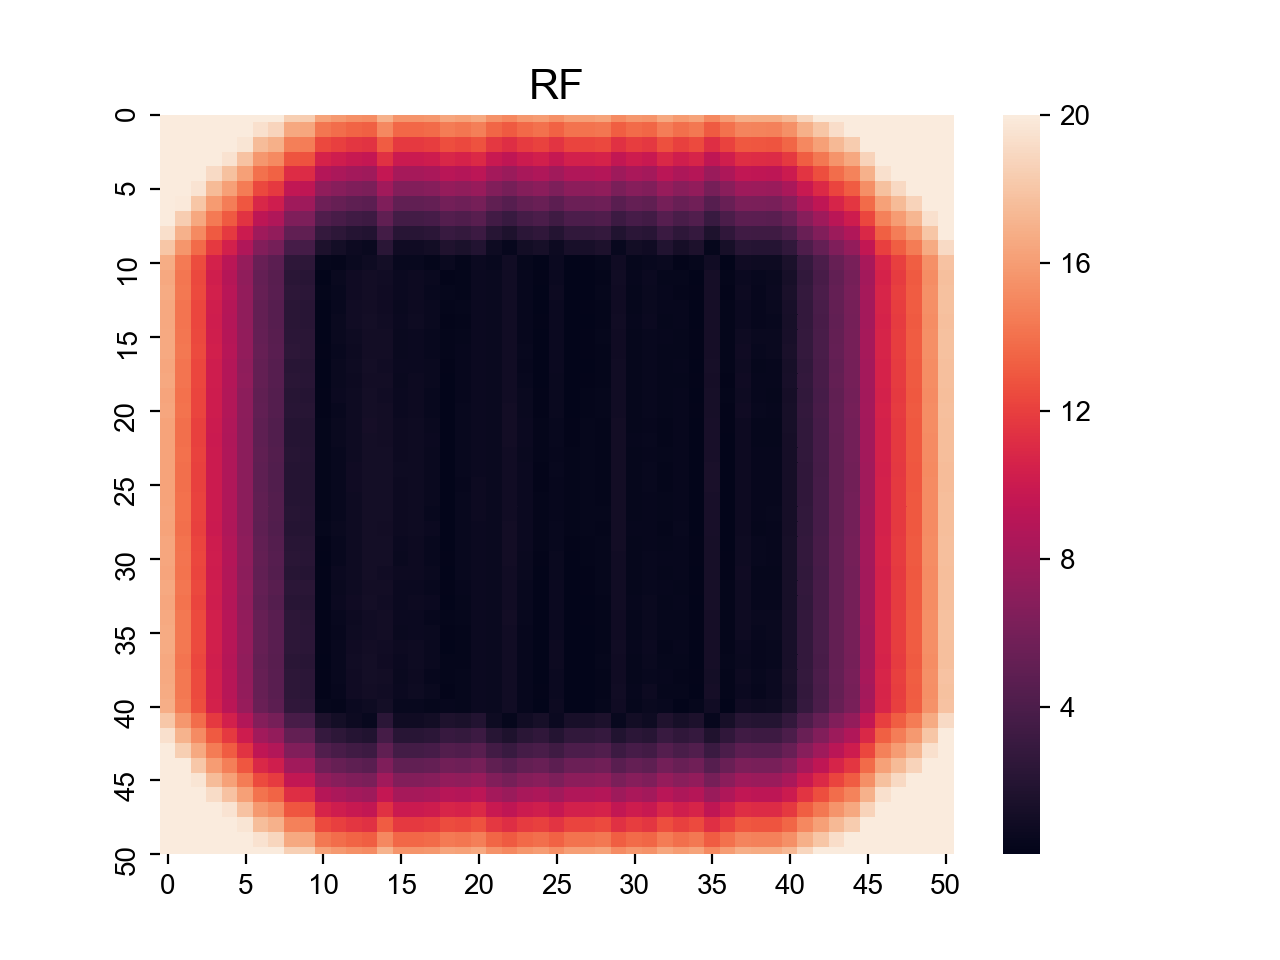

In [9]:
heat(Y_test, Yp_test_RF, vmax=20, width=x1_test, length=x2_test, ticklabel=5, title="RF", fontsize=15)

## Proposed method

<IPython.core.display.Javascript object>


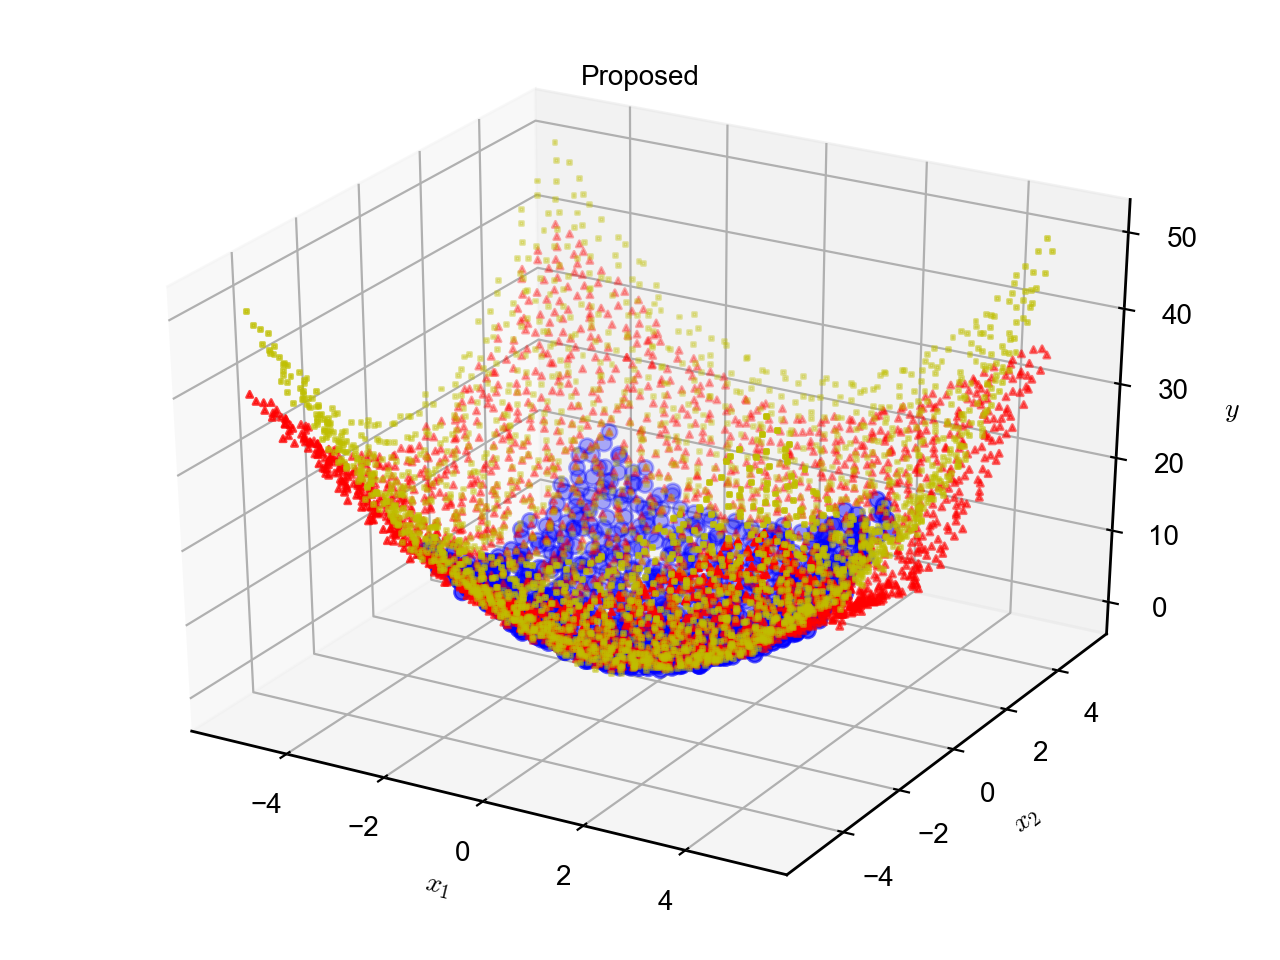

In [11]:
model_Proposed = StochasticThresholdModelTrees(
    n_estimators=300,
    criterion=MSE(),
    regressor=LinearRegression(),
    threshold_selector=NormalGaussianDistribution(5),
    min_samples_split=6,
    min_samples_leaf=3,
    ensemble_pred='median',
    f_select=False,
    scaling=True)
model_Proposed.fit(X_train, Y_train)
Yp_test_Proposed = model_Proposed.predict(X_test)

my_plot(X1_train, X2_train, Y_train, X1_test, X2_test, Y_test, Yp_test_Proposed, title="Proposed")

<IPython.core.display.Javascript object>


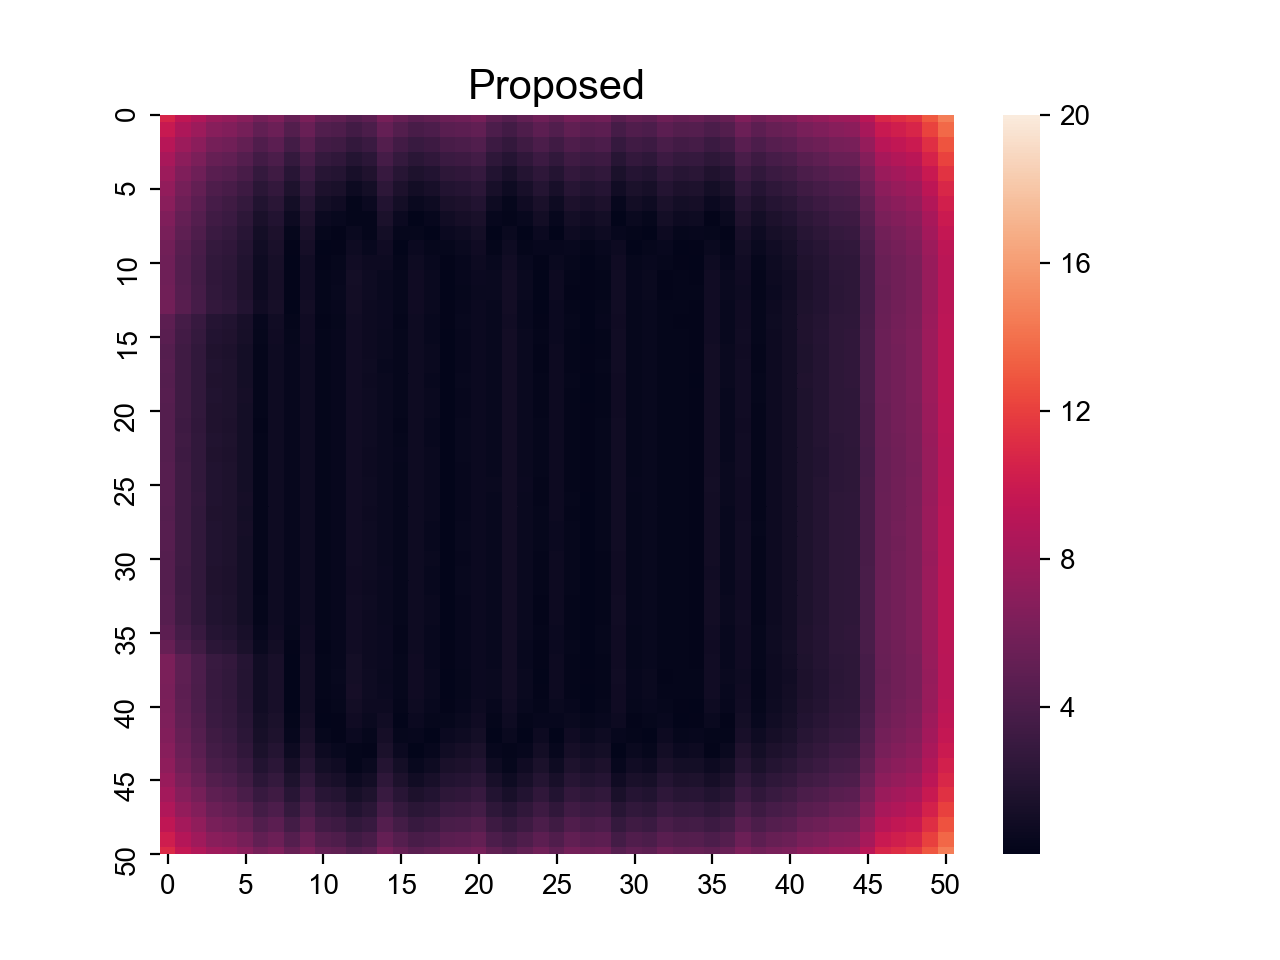

In [12]:
heat(Y_test, Yp_test_Proposed, vmax=20, width=x1_test, length=x2_test, ticklabel=5, title="Proposed", fontsize=15)